In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
# --------------------
# 📌 1. Connexion à PostgreSQL
# --------------------
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Configuration de connexion
USER = "postgres"
PASSWORD = "159753"
HOST = "localhost"
PORT = "5432"
DB = "SupplyChain_DW"

# Création de l'engine SQLAlchemy
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}')

In [3]:
# === Requête SQL ===
query = """
SELECT *
  FROM public."Dim_Equipment";
"""

In [4]:
# === Chargement dans un DataFrame pandas ===
df_equip = pd.read_sql(query, engine)

# === Affichage rapide ===
print(df_equip.head())

   id_equipment_PK Machine_ID  \
0                1  MACH-0001   
1                2  MACH-0002   
2                3  MACH-0003   
3                4  MACH-0004   
4                5  MACH-0005   

                                                Name               Reason  \
0  Nouvelle machine à fabriquer des sachets à fer...   Mechanical Failure   
1  Machine de mélangeur à haute cisaillement pour...                        
2  Machine de fabrication de crème cosmétique, mé...                        
3  Équipement de mélangeur émulsifiant à vide pou...   Mechanical Failure   
4  500L Machine à faire du savon à vaisselle pour...  Regular Maintenance   

      Maintenance_Notes Inspection_Date     Inspector Issues_Found      Price  \
0  Replaced minor parts      2024-10-19  Robert Brown   Minor wear   6600.000   
1      Routine check-up      2023-09-22   Alice Smith   Minor wear    560.000   
2  Replaced minor parts      2023-09-06   Emily White         None  13500.000   
3  Replaced mi

In [5]:
df_equipNew = df_equip.drop(['Inspection_Date'], axis=1)

In [6]:
df_equipNew

,id_equipment_PK,Machine_ID,Name,Reason,Maintenance_Notes,Inspector,Issues_Found,Price,Performance,Resolution
0,1,MACH-0001,Nouvelle machine à fabriquer des sachets à fer...,Mechanical Failure,Replaced minor parts,Robert Brown,Minor wear,6600.000,Medium-Low,Fixed during inspection
1,2,MACH-0002,Machine de mélangeur à haute cisaillement pour...,,Routine check-up,Alice Smith,Minor wear,560.000,Low,Fixed during inspection
2,3,MACH-0003,"Machine de fabrication de crème cosmétique, mé...",,Replaced minor parts,Emily White,None,13500.000,Medium,No action needed
3,4,MACH-0004,Équipement de mélangeur émulsifiant à vide pou...,Mechanical Failure,Replaced minor parts,Robert Brown,Minor wear,22975.826,Medium-High,Fixed during inspection
4,5,MACH-0005,500L Machine à faire du savon à vaisselle pour...,Regular Maintenance,Replaced minor parts,Emily White,Loose bolts,8686.000,Medium-Low,Fixed during inspection
...,...,...,...,...,...,...,...,...,...,...
2995,2996,MACH-2996,Machine à fabriquer des cosmétiques quotidienn...,Regular Maintenance,Replaced minor parts,Emily White,Minor wear,22975.826,Medium-High,Fixed during inspection
2996,2997,MACH-2997,1000L Équipement de fabrication de cosmétiques...,,Replaced minor parts,Alice Smith,None,18500.000,Medium,No action needed
2997,2998,MACH-2998,Mixeur homogénéisateur cosmétique automatique ...,,Routine check-up,Alice Smith,Software glitch,22975.826,Medium-High,Fixed during inspection
2998,2999,MACH-2999,Équipement de fabrication de crème cosmétique ...,,Routine check-up,Robert Brown,Loose bolts,4500.000,Low,Fixed during inspection


In [7]:
# === Requête SQL ===
query = """
SELECT "FK_equip", "FK_downStartDate", "FK_downEndDate", "Reason", "Performance", "id_InspectionDate_FK"
	FROM public."Fact_Maintenance";
"""
# === Chargement dans un DataFrame pandas ===
df_FactMaint = pd.read_sql(query, engine)
df_FactMaint.head(5)

,FK_equip,FK_downStartDate,FK_downEndDate,Reason,Performance,id_InspectionDate_FK
0,1,14401,25993,Mechanical Failure,Medium-Low,24529
1,4,12289,14257,Mechanical Failure,Medium-High,20761
2,5,21073,26257,Regular Maintenance,Medium-Low,23257
3,6,12337,18481,Software Issue,Medium-High,25729
4,7,10057,19153,Mechanical Failure,Low,11617


In [8]:
# === Requête SQL ===
query = """
SELECT "id_Date_pk", fulldate
	FROM public."Dim_Date";
"""

In [9]:
# === Chargement dans un DataFrame pandas ===
df_date = pd.read_sql(query, engine)

# === Affichage rapide ===
print(df_date.head())

   id_Date_pk            fulldate
0           1 2022-01-01 00:00:00
1           2 2022-01-01 01:00:00
2           3 2022-01-01 02:00:00
3           4 2022-01-01 03:00:00
4           5 2022-01-01 04:00:00


# Then we merged the two dataframes

In [10]:
# Étape 1 : Jointure entre équipements et faits de maintenance
Maintenance = pd.merge(
    df_equipNew,
    df_FactMaint,
    left_on='id_equipment_PK',
    right_on='FK_equip',
    how='inner'
)

# Étape 2 : Jointure pour ajouter la date de début d'arrêt
Maintenance = Maintenance.merge(
    df_date.rename(columns={"id_Date_pk": "FK_downStartDate", "DT_JOUR": "downStartDate"}),
    on="FK_downStartDate",
    how="left"
)

# Étape 3 : Jointure pour ajouter la date de fin d'arrêt
Maintenance = Maintenance.merge(
    df_date.rename(columns={"id_Date_pk": "FK_downEndDate", "DT_JOUR": "downEndDate"}),
    on="FK_downEndDate",
    how="left"
)

# Étape 4 : Suppression des colonnes FK de dates (devenues inutiles)
Maintenance.drop(columns=["FK_downStartDate", "FK_downEndDate"], inplace=True)


In [11]:
Maintenance

,id_equipment_PK,Machine_ID,Name,Reason_x,Maintenance_Notes,Inspector,Issues_Found,Price,Performance_x,Resolution,FK_equip,Reason_y,Performance_y,id_InspectionDate_FK,fulldate_x,fulldate_y
0,1,MACH-0001,Nouvelle machine à fabriquer des sachets à fer...,Mechanical Failure,Replaced minor parts,Robert Brown,Minor wear,6600.000,Medium-Low,Fixed during inspection,1,Mechanical Failure,Medium-Low,24529,2023-08-24,2024-12-19
1,4,MACH-0004,Équipement de mélangeur émulsifiant à vide pou...,Mechanical Failure,Replaced minor parts,Robert Brown,Minor wear,22975.826,Medium-High,Fixed during inspection,4,Mechanical Failure,Medium-High,20761,2023-05-28,2023-08-18
2,5,MACH-0005,500L Machine à faire du savon à vaisselle pour...,Regular Maintenance,Replaced minor parts,Emily White,Loose bolts,8686.000,Medium-Low,Fixed during inspection,5,Regular Maintenance,Medium-Low,23257,2024-05-28,2024-12-30
3,6,MACH-0006,Populaire émulsifiant mélange réacteur coloran...,Software Issue,Replaced minor parts,Robert Brown,Minor wear,22975.826,Medium-High,Fixed during inspection,6,Software Issue,Medium-High,25729,2023-05-30,2024-02-10
4,7,MACH-0007,"Cuve de mélange cosmétique, machine de mélange...",Mechanical Failure,Replaced minor parts,Robert Brown,Loose bolts,4500.000,Low,Fixed during inspection,7,Mechanical Failure,Low,11617,2023-02-24,2024-03-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,2990,MACH-2990,Machine à mélanger des lotions en acier inoxyd...,Mechanical Failure,Replaced minor parts,Emily White,None,22975.826,Medium-High,No action needed,2990,Mechanical Failure,Medium-High,19321,2023-11-05,2024-07-31
1488,2991,MACH-2991,Machine de fabrication de crème cosmétique de ...,Regular Maintenance,Replaced minor parts,John Doe,Loose bolts,14200.000,Medium,Fixed during inspection,2991,Regular Maintenance,Medium,22489,2023-10-31,2024-10-02
1489,2992,MACH-2992,Équipement de fabrication de crème solaire cos...,Regular Maintenance,Replaced minor parts,Emily White,None,22975.826,Medium-High,No action needed,2992,Regular Maintenance,Medium-High,15985,2023-07-22,2024-03-02
1490,2994,MACH-2994,Machine de mélangeur de détergent liquide de h...,Power Outage,Replaced minor parts,John Doe,Software glitch,22975.826,Medium-High,Fixed during inspection,2994,Power Outage,Medium-High,24217,2024-12-15,2025-01-01


# Objectif non supervisé : Segmenter les machines selon leur profil de performance et de maintenance

## Création de la colonne durée d'arrêt

In [12]:
# 1. Conversion en datetime
Maintenance["fulldate_x"] = pd.to_datetime(Maintenance["fulldate_x"])
Maintenance["fulldate_y"] = pd.to_datetime(Maintenance["fulldate_y"])

# 2. Calcul de la durée d'arrêt en jours
Maintenance["downtime_duration"] = (Maintenance["fulldate_y"] - Maintenance["fulldate_x"]).dt.days
Maintenance



,id_equipment_PK,Machine_ID,Name,Reason_x,Maintenance_Notes,Inspector,Issues_Found,Price,Performance_x,Resolution,FK_equip,Reason_y,Performance_y,id_InspectionDate_FK,fulldate_x,fulldate_y,downtime_duration
0,1,MACH-0001,Nouvelle machine à fabriquer des sachets à fer...,Mechanical Failure,Replaced minor parts,Robert Brown,Minor wear,6600.000,Medium-Low,Fixed during inspection,1,Mechanical Failure,Medium-Low,24529,2023-08-24,2024-12-19,483
1,4,MACH-0004,Équipement de mélangeur émulsifiant à vide pou...,Mechanical Failure,Replaced minor parts,Robert Brown,Minor wear,22975.826,Medium-High,Fixed during inspection,4,Mechanical Failure,Medium-High,20761,2023-05-28,2023-08-18,82
2,5,MACH-0005,500L Machine à faire du savon à vaisselle pour...,Regular Maintenance,Replaced minor parts,Emily White,Loose bolts,8686.000,Medium-Low,Fixed during inspection,5,Regular Maintenance,Medium-Low,23257,2024-05-28,2024-12-30,216
3,6,MACH-0006,Populaire émulsifiant mélange réacteur coloran...,Software Issue,Replaced minor parts,Robert Brown,Minor wear,22975.826,Medium-High,Fixed during inspection,6,Software Issue,Medium-High,25729,2023-05-30,2024-02-10,256
4,7,MACH-0007,"Cuve de mélange cosmétique, machine de mélange...",Mechanical Failure,Replaced minor parts,Robert Brown,Loose bolts,4500.000,Low,Fixed during inspection,7,Mechanical Failure,Low,11617,2023-02-24,2024-03-09,379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,2990,MACH-2990,Machine à mélanger des lotions en acier inoxyd...,Mechanical Failure,Replaced minor parts,Emily White,None,22975.826,Medium-High,No action needed,2990,Mechanical Failure,Medium-High,19321,2023-11-05,2024-07-31,269
1488,2991,MACH-2991,Machine de fabrication de crème cosmétique de ...,Regular Maintenance,Replaced minor parts,John Doe,Loose bolts,14200.000,Medium,Fixed during inspection,2991,Regular Maintenance,Medium,22489,2023-10-31,2024-10-02,337
1489,2992,MACH-2992,Équipement de fabrication de crème solaire cos...,Regular Maintenance,Replaced minor parts,Emily White,None,22975.826,Medium-High,No action needed,2992,Regular Maintenance,Medium-High,15985,2023-07-22,2024-03-02,224
1490,2994,MACH-2994,Machine de mélangeur de détergent liquide de h...,Power Outage,Replaced minor parts,John Doe,Software glitch,22975.826,Medium-High,Fixed during inspection,2994,Power Outage,Medium-High,24217,2024-12-15,2025-01-01,17


In [13]:
Maintenance =Maintenance.dropna(subset=['Performance_x'])
machine_counts = Maintenance['Performance_x'].value_counts()
print(machine_counts)
# Define mapping
category_map = {
    'High': 'High',
    'Medium-High': 'High',
    'Medium': 'Medium',
    'Medium-Low': 'Low',
    'Low': 'Low'
}

# Overwrite the same column
Maintenance['Performance_x'] = Maintenance['Performance_x'].map(category_map)

# Check the result
print(Maintenance['Performance_x'].value_counts())


Performance_x
Medium-High    802
Medium         262
Low            203
High           150
Medium-Low      75
Name: count, dtype: int64
Performance_x
High      952
Low       278
Medium    262
Name: count, dtype: int64


In [14]:
from sklearn.utils import resample

# Separate classes
high = Maintenance[Maintenance['Performance_x'] == 'High']
medium = Maintenance[Maintenance['Performance_x'] == 'Medium']
low = Maintenance[Maintenance['Performance_x'] == 'Low']

# Determine target size (max class size)
max_size = max(len(high), len(medium), len(low))

# Upsample each class
high = resample(high, replace=True, n_samples=max_size, random_state=42)
medium = resample(medium, replace=True, n_samples=max_size, random_state=42)
low = resample(low, replace=True, n_samples=max_size, random_state=42)

# Combine into one DataFrame
Maintenance = pd.concat([high, medium, low]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check the result
print(Maintenance['Performance_x'].value_counts())


Performance_x
Medium    952
High      952
Low       952
Name: count, dtype: int64


## We encoded the categorical variables and normalized our data

In [15]:
# Initialisation des encodeurs
le_perf = LabelEncoder()
le_issues = LabelEncoder()
le_reason = LabelEncoder()

# Création des colonnes encodées sans toucher aux colonnes initiales
Maintenance["Perf_encoded"] = le_perf.fit_transform(Maintenance["Performance_x"].astype(str))
Maintenance["Issues_encoded"] = le_issues.fit_transform(Maintenance["Issues_Found"].astype(str))
Maintenance["Reason_encoded"] = le_reason.fit_transform(Maintenance["Reason_x"].astype(str))

# Affichage du DataFrame pour vérifier les modifications
print(Maintenance.head())


   id_equipment_PK Machine_ID  \
0             1639  MACH-1639   
1             1251  MACH-1251   
2              305  MACH-0304   
3              336  MACH-0335   
4             2546  MACH-2546   

                                                Name             Reason_x  \
0  Équipement de mélangeur émulsifiant à vide pou...  Regular Maintenance   
1  Machine de fabrication de crème cosmétique de ...       Software Issue   
2  Équipement de mélangeur émulsifiant à vide pou...       Software Issue   
3  500L Machine à faire du savon à vaisselle pour...       Software Issue   
4  Machine à fabriquer des cosmétiques quotidienn...   Mechanical Failure   

      Maintenance_Notes     Inspector     Issues_Found      Price  \
0  Replaced minor parts  Robert Brown       Minor wear  13500.000   
1  Replaced minor parts   Emily White      Loose bolts  14200.000   
2  Replaced minor parts   Emily White  Software glitch  22975.826   
3  Replaced minor parts   Alice Smith       Minor wear   8686.

### The variables needed for segmentation

In [16]:
features = Maintenance[["Price", "Perf_encoded", "Issues_encoded", "Reason_encoded", "downtime_duration"]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Data Modeling : CAH


In [17]:
Z = linkage(scaled_features, method='ward') #minimise la variance intra-cluster

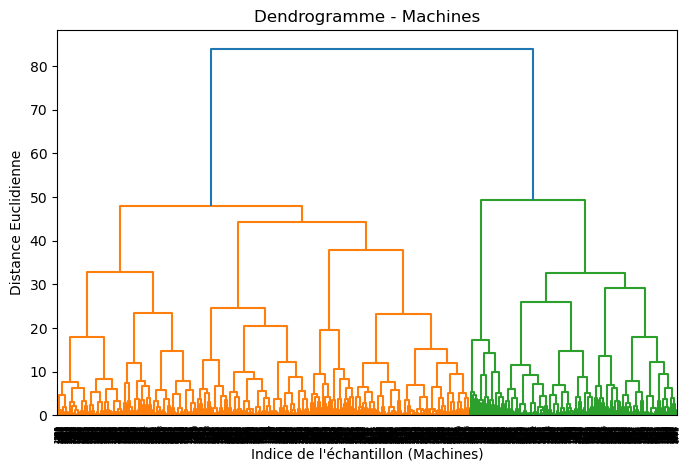

In [29]:
plt.figure(figsize=(8, 5))
dendrogram(Z)
plt.title("Dendrogramme - Machines")
plt.xlabel("Indice de l'échantillon (Machines)")
plt.ylabel("Distance Euclidienne")
plt.show()

### To ensure a more balanced segmentation, the optimal cut appears to be around distance = 35, which results in 2 quasi-identical groups in terms of number of machines.

### Then, we move on to applying Kmeans:

In [30]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)  #reproduire les mêmes résultats à chaque exécution , Essaye 10 configurations différentes et garde la meilleure
Maintenance["cluster"] = kmeans.fit_predict(scaled_features)

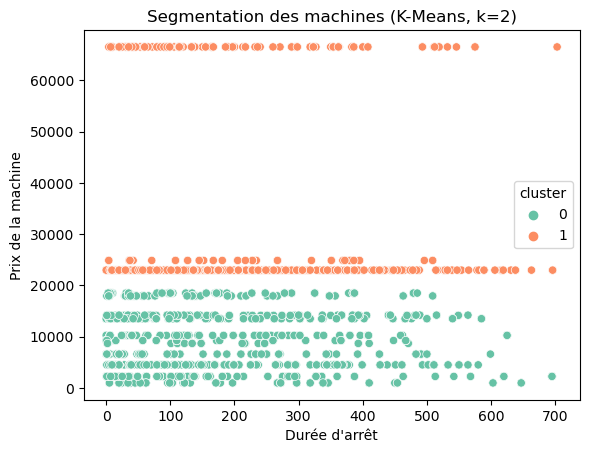

          Price  downtime_duration  cluster
0     13500.000                130        0
1     14200.000                384        0
2     22975.826                146        1
3      8686.000                111        0
4     22975.826                 90        1
...         ...                ...      ...
2851  13500.000                 98        0
2852  14200.000                 20        0
2853  13500.000                262        0
2854  17944.494                  4        0
2855  22975.826                158        1

[2856 rows x 3 columns]


In [31]:
# Visualisation des clusters selon la durée d'arrêt et le prix
sns.scatterplot(data=Maintenance, x="downtime_duration", y="Price", hue="cluster", palette="Set2")
plt.title("Segmentation des machines (K-Means, k=2)")
plt.xlabel("Durée d'arrêt")
plt.ylabel("Prix de la machine")
plt.show()

# Aperçu des résultats
print(Maintenance[["Price", "downtime_duration", "cluster"]])

🔴 Cluster 1 (rouge) :
Machines très chères (toutes au-dessus de 65,000)

Avec des durées d’arrêt relativement faibles. \
📌 Hypothèse : Ce sont des machines haut de gamme, bien entretenues, performantes

🟢 Cluster 0 (vert) :
Machines de prix bas à moyen

Avec des durées d’arrêt élevées (parfois > 600 !) 

📌 Hypothèse : Ce sont des machines vieillissantes, sujettes aux pannes.
    

Machines de prix moyen (entre 5000 et 25000)

Avec des durées d’arrêt modérées à faibles

📌 Hypothèse : Ce sont des machines standards ou en bon état général.

In [22]:
# Exportation vers un fichier CSV
Maintenance.to_csv("C:/Users/Hadhemi/Documents/resultat_segmentation.csv", index=False)

# Objectif 2 : Prédire la performance future d’une machine (haute, moyenne, faible) : RandomForest

In [41]:
pip install flask scikit-learn xgboost numpy pandas joblib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [32]:
from flask import Flask, jsonify, render_template , request
import joblib
import numpy as np

In [19]:
# Calcul du score z pour la colonne 'Price' et ajout dans une nouvelle colonne
Maintenance['price_zscore'] = (Maintenance['Price'] - Maintenance['Price'].mean()) / Maintenance['Price'].std()

# Affichage du DataFrame pour vérifier la nouvelle colonne
print(Maintenance.head())


   id_equipment_PK Machine_ID  \
0             1639  MACH-1639   
1             1251  MACH-1251   
2              305  MACH-0304   
3              336  MACH-0335   
4             2546  MACH-2546   

                                                Name             Reason_x  \
0  Équipement de mélangeur émulsifiant à vide pou...  Regular Maintenance   
1  Machine de fabrication de crème cosmétique de ...       Software Issue   
2  Équipement de mélangeur émulsifiant à vide pou...       Software Issue   
3  500L Machine à faire du savon à vaisselle pour...       Software Issue   
4  Machine à fabriquer des cosmétiques quotidienn...   Mechanical Failure   

      Maintenance_Notes     Inspector     Issues_Found      Price  \
0  Replaced minor parts  Robert Brown       Minor wear  13500.000   
1  Replaced minor parts   Emily White      Loose bolts  14200.000   
2  Replaced minor parts   Emily White  Software glitch  22975.826   
3  Replaced minor parts   Alice Smith       Minor wear   8686.

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier



# Cible
y = Maintenance["Perf_encoded"]

# Variables explicatives
X = Maintenance[["price_zscore", "Issues_encoded", "Reason_encoded"]]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Modélisation
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

# Sauvegardes
joblib.dump(model, "performance2_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le_issue, "le_issue.pkl")
joblib.dump(le_reason, "le_reason.pkl")

print("✅ Modèle et encodeurs sauvegardés avec succès.")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       190
           1       0.99      0.98      0.99       191
           2       0.98      0.99      0.99       191

    accuracy                           0.99       572
   macro avg       0.99      0.99      0.99       572
weighted avg       0.99      0.99      0.99       572

Matrice de confusion:
[[190   0   0]
 [  0 188   3]
 [  0   2 189]]
✅ Modèle et encodeurs sauvegardés avec succès.


### Les éléments en diagonale sont les bons classés. Les éléments hors diagonale représentent des erreurs. Ici il n'y en a aucune. Cela confirme le score parfait du classification_report

### Objectif : Recommandation
### Étant donné les caractéristiques d'une machine (type, prix, problème rencontré, cause de panne, performance), prédire combien de temps cette machine restera à l'arrêt si aucune action n’est prise immédiatement.

In [59]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# === 3. Encodage des variables catégorielles ===
categorical_cols = ['Issues_Found', 'Reason_x', 'Performance_y', 'Resolution']
label_encoders = {}

# Créer un DataFrame pour stocker les valeurs encodées
encoded_data = Maintenance.copy()

for col in categorical_cols:
    le = LabelEncoder()
    encoded_data[col + '_encoded'] = le.fit_transform(encoded_data[col].astype(str))
    label_encoders[col] = le

# Affichage du DataFrame avec les nouvelles colonnes encodées
print(encoded_data.head())

   id_equipment_PK Machine_ID  \
0             1639  MACH-1639   
1             1251  MACH-1251   
2              305  MACH-0304   
3              336  MACH-0335   
4             2546  MACH-2546   

                                                Name  Reason_x  \
0  Équipement de mélangeur émulsifiant à vide pou...         2   
1  Machine de fabrication de crème cosmétique de ...         3   
2  Équipement de mélangeur émulsifiant à vide pou...         3   
3  500L Machine à faire du savon à vaisselle pour...         3   
4  Machine à fabriquer des cosmétiques quotidienn...         0   

      Maintenance_Notes     Inspector  Issues_Found      Price Performance_x  \
0  Replaced minor parts  Robert Brown             1  13500.000        Medium   
1  Replaced minor parts   Emily White             0  14200.000        Medium   
2  Replaced minor parts   Emily White             3  22975.826          High   
3  Replaced minor parts   Alice Smith             1   8686.000           Low   
4  R

In [50]:
Maintenance

,id_equipment_PK,Machine_ID,Name,Reason_x,Maintenance_Notes,Inspector,Issues_Found,Price,Performance_x,Resolution,...,Performance_y,id_InspectionDate_FK,fulldate_x,fulldate_y,downtime_duration,Perf_encoded,Issues_encoded,Reason_encoded,cluster,price_zscore
0,1639,MACH-1639,Équipement de mélangeur émulsifiant à vide pou...,2,Replaced minor parts,Robert Brown,1,13500.000,Medium,0,...,2,11713,2023-01-10,2023-05-20,130,2,1,2,0,-0.198534
1,1251,MACH-1251,Machine de fabrication de crème cosmétique de ...,3,Replaced minor parts,Emily White,0,14200.000,Medium,0,...,2,23689,2023-12-12,2024-12-30,384,2,0,3,0,-0.149725
2,305,MACH-0304,Équipement de mélangeur émulsifiant à vide pou...,3,Replaced minor parts,Emily White,3,22975.826,High,0,...,3,22633,2023-02-11,2023-07-07,146,0,3,3,1,0.462176
3,336,MACH-0335,500L Machine à faire du savon à vaisselle pour...,3,Replaced minor parts,Alice Smith,1,8686.000,Low,0,...,4,18217,2024-04-07,2024-07-27,111,1,1,3,0,-0.534194
4,2546,MACH-2546,Machine à fabriquer des cosmétiques quotidienn...,0,Replaced minor parts,John Doe,3,22975.826,High,0,...,3,21553,2024-05-24,2024-08-22,90,0,3,0,1,0.462176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,694,MACH-0693,"Machine de fabrication de crème cosmétique, mé...",3,Replaced minor parts,Alice Smith,1,13500.000,Medium,0,...,2,19897,2024-04-03,2024-07-10,98,2,1,3,0,-0.198534
2852,1431,MACH-1431,Machine de fabrication de crème cosmétique de ...,0,Replaced minor parts,Alice Smith,1,14200.000,Medium,0,...,2,21985,2024-12-12,2025-01-01,20,2,1,0,0,-0.149725
2853,1909,MACH-1909,Équipement de mélangeur émulsifiant à vide pou...,0,Replaced minor parts,Robert Brown,1,13500.000,Medium,0,...,2,17065,2023-05-01,2024-01-18,262,2,1,0,0,-0.198534
2854,2935,MACH-2935,"Machine de fabrication de crème cosmétique, mé...",0,Replaced minor parts,Alice Smith,0,17944.494,Medium,0,...,2,14641,2024-12-10,2024-12-14,4,2,0,0,0,0.111363


In [ ]:
# Exportation vers un fichier CSV
Maintenance.to_csv("C:/Users/Hadhemi/Documents/Maintenance.csv", index=False)# --------------------
# 📌 1. Connexion à PostgreSQL
# --------------------
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Configuration de connexion
USER = "postgres"
PASSWORD = "159753"
HOST = "localhost"
PORT = "5432"
DB = "SupplyChain_DW"

# Création de l'engine SQLAlchemy
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}')

In [22]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Cible
y = Maintenance["Perf_encoded"]

# Variables explicatives
X = Maintenance[["price_zscore", "Issues_encoded", "Reason_encoded"]]

# --- 2. Normalisation 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Séparation des données ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Modélisation ---
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)

# --- 5. Prédictions ---
y_pred = model.predict(X_test)

# --- 6. Évaluation ---
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

# Sauvegarde du modèle dans un fichier .pkl
model_filename = "performance_model.pkl"
joblib.dump(model, model_filename)

# Sauvegarde du scaler dans un fichier .pkl
scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)
joblib.dump(le_issues, "le_issues.pkl")
joblib.dump(le_reason, "le_reason.pkl")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       190
           1       0.99      0.98      0.99       191
           2       0.98      0.99      0.99       191

    accuracy                           0.99       572
   macro avg       0.99      0.99      0.99       572
weighted avg       0.99      0.99      0.99       572

Matrice de confusion:
[[190   0   0]
 [  0 188   3]
 [  0   2 189]]


['le_reason.pkl']

In [57]:
print(le_issue.classes_)


[0 1 2 3]


### Objectif : "Prévoir le nombre d'arrêts de machines par mois"

In [40]:
# Charger les dates
Maintenance['fulldate_x'] = pd.to_datetime(Maintenance['fulldate_x'])

# Créer une série temporelle : nombre d'arrêts par mois
stops_per_month = Maintenance['fulldate_x'].dt.to_period('M').value_counts().sort_index()
stops_per_month.index = stops_per_month.index.to_timestamp()

In [41]:
# Séparer en train/test (70/30)
split_idx = int(len(stops_per_month) * 0.7)
train_data = stops_per_month.iloc[:split_idx]
test_data = stops_per_month.iloc[split_idx:]

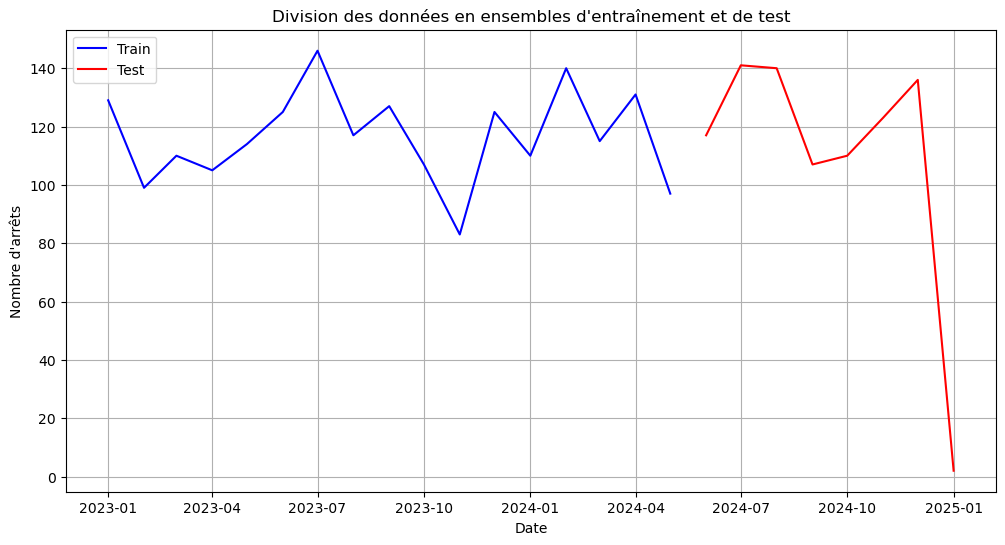

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train', color='blue')
plt.plot(test_data, label='Test', color='red')
plt.title("Division des données en ensembles d'entraînement et de test")
plt.xlabel("Date")
plt.ylabel("Nombre d'arrêts")
plt.legend()
plt.grid(True)
plt.show()

### We notice a significant decrease starting from the year 2025.

In [43]:
max_lags = min(20, len(train_array) // 2)


NameError: name 'train_array' is not defined

# ACF et PACF
## Then, we calculated the number of lags (nlags) for ACF and PACF

In [44]:
max_lags_acf = min(20, len(train_array) - 1)
max_lags_pacf = min(20, (len(train_array) // 2) - 1)

# ACF
plot_acf(train_array, lags=max_lags_acf)
plt.title("Autocorrelation")
plt.show()

# PACF
plot_pacf(train_array, lags=max_lags_pacf)
plt.title("Partial Autocorrelation")
plt.show()


NameError: name 'train_array' is not defined

## Le graphique ACF montre comment les valeurs de ta série (nombre d’arrêts par mois) sont corrélées avec leurs valeurs passées (lags).
### La série ne montre pas de saisonnalité ou dépendance forte dans le temps.




## Le PACF montre la corrélation directe entre une observation et ses lags, en contrôlant les effets intermédiaires.
### Il n’y a pas de structure AR (AutoRegressive) forte sur le court terme.
Les valeurs passées immédiates (1 mois avant, 2 mois avant) n’ont pas d’influence directe significative sur la valeur actuelle de la série.

# SARIMA Model

In [45]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

print(results.summary())


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              count   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -18.406
Date:                            Sun, 11 May 2025   AIC                             46.813
Time:                                    04:36:19   BIC                             43.744
Sample:                                01-01-2023   HQIC                            40.079
                                     - 05-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9990     34.736     -0.029      0.977     -69.080      67.082
ma.L1          0.9723    475.100   

In [47]:
import joblib

# Sauvegarder le modèle dans un fichier .pkl
joblib.dump(results, "C:/Users/Hadhemi/Documents/time_series_model.pkl")


['C:/Users/Hadhemi/Documents/time_series_model.pkl']

 Ljung-Box (L1) (Q): 0.30 / Prob(Q): 0.95
Prob(Q) = 0.95 > 0.05 → ✅ On ne rejette pas l'hypothèse 0 → les résidus ne sont pas significativement autocorrélés, ce qui est une bonne chose

Jarque-Bera (JB): 0.47 / Prob(JB): 0.79
Teste si les résidus suivent une distribution normale (normalité des erreurs).

Prob(JB) = 0.84 > 0.05 → ✅ les résidus semblent normalement distribués, ce qui est également bon signe.



## ✅ Les résidus sont globalement satisfaisants, ce qui valide la qualité du modèle SARIMA, malgré des incertitudes liées à la faible taille de l’échantillon.

## Prédiction sur les mois futurs

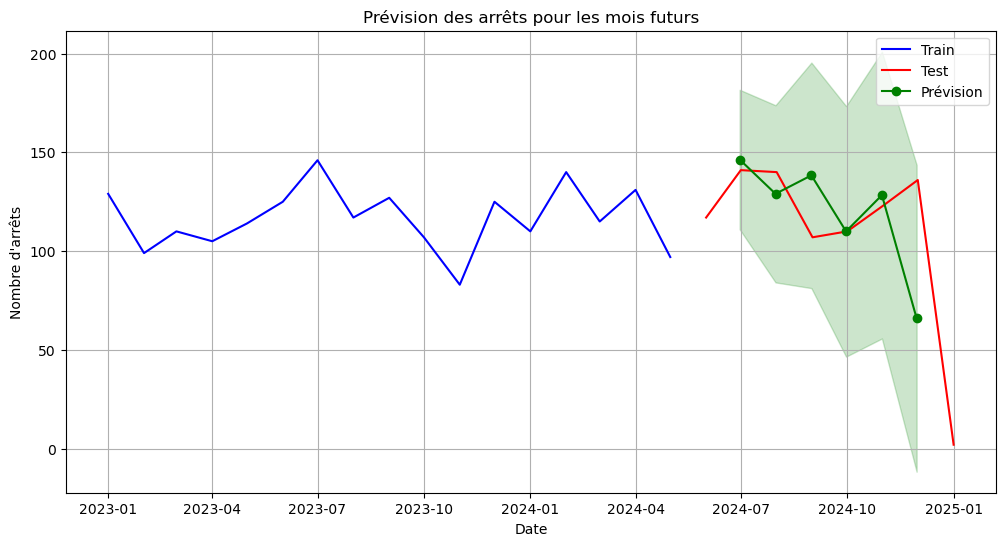

In [46]:
# Prédire les N prochains mois (ex: 6 mois)
n_months = 6

# Étendre la série dans le futur
future_index = pd.date_range(start=train_data.index[-1] + pd.DateOffset(months=1), periods=n_months, freq='M')

# Prédiction
forecast = results.get_forecast(steps=n_months)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Affichage
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train', color='blue')
plt.plot(test_data, label='Test', color='red')
plt.plot(future_index, forecast_mean, label='Prévision', color='green', marker='o')
plt.fill_between(future_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='green', alpha=0.2)
plt.title("Prévision des arrêts pour les mois futurs")
plt.xlabel("Date")
plt.ylabel("Nombre d'arrêts")
plt.legend()
plt.grid(True)
plt.show()


## Le modèle suit raisonnablement bien la dynamique des données de test, surtout entre juin et novembre 2024.